<a href="https://colab.research.google.com/github/durel18/E-commerceApp/blob/master/Durel_Tankoua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Copyright 2020 Google LLC. Double-click here for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In this Lab, we use a real dataset to predict the prices of houses in California.   

# Learning Objectives:

After doing this lab, you'll know how to do the following:

  * Read a .csv file into a [pandas](https://developers.google.com/machine-learning/glossary/#pandas) DataFrame.
  * Examine a [dataset](https://developers.google.com/machine-learning/glossary/#data_set).
  * Experiment with different [features](https://developers.google.com/machine-learning/glossary/#feature) in building a model.
  * Tune the model's [hyperparameters](https://developers.google.com/machine-learning/glossary/#hyperparameter).

## The Dataset

  
The [dataset for this lab](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) is based on 1990 census data from California. The dataset is old but still provides a great opportunity to learn about machine learning programming.

## Import relevant modules

The following hidden code cell imports the necessary modules to run the code in the rest of this Colaboratory.

In [ ]:
#@title Import relevant modules
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

## The dataset

Datasets are often stored on disk or at a URL in [.csv format](https://wikipedia.org/wiki/Comma-separated_values).

A well-formed .csv file contains column names in the first row, followed by many rows of data.  A comma divides each value in each row. For example, here are the first five rows of the .csv file holding the California Housing Dataset:

```
"longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"
-114.310000,34.190000,15.000000,5612.000000,1283.000000,1015.000000,472.000000,1.493600,66900.000000
-114.470000,34.400000,19.000000,7650.000000,1901.000000,1129.000000,463.000000,1.820000,80100.000000
-114.560000,33.690000,17.000000,720.000000,174.000000,333.000000,117.000000,1.650900,85700.000000
-114.570000,33.640000,14.000000,1501.000000,337.000000,515.000000,226.000000,3.191700,73400.000000
```



### Load the .csv file into a pandas DataFrame



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Import the dataset.
training_df = pd.read_csv(filepath_or_buffer="https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=',')

training_df.head()

# Scale the label.
training_df["median_house_value"] /= 1000.0

# Print the first rows of the pandas DataFrame.
training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5


Scaling `median_house_value` puts the value of each house in units of thousands. Scaling will keep loss values and learning rates in a friendlier range.  

Although scaling a label is usually *not* essential, scaling features in a multi-feature model usually *is* essential.

## Examine the dataset

A large part of most machine learning projects is getting to know your data. The pandas API provides a `describe` function that outputs the following statistics about every column in the DataFrame:

* `count`, which is the number of rows in that column. Ideally, `count` contains the same value for every column.

* `mean` and `std`, which contain the mean and standard deviation of the values in each column.

* `min` and `max`, which contain the lowest and highest values in each column.

* `25%`, `50%`, `75%`, which contain various [quantiles](https://developers.google.com/machine-learning/glossary/#quantile).

In [ ]:
# Get statistics on the dataset.
training_df.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


## Define functions that build and train a model

The following code defines two functions:

  * `build_model(my_learning_rate)`, which builds a randomly-initialized model.
  * `train_model(model, feature, label, epochs)`, which trains the model from the examples (feature and label) you pass.

The details of these functions are very valuable but you can skip them now because they are not relevant to the learning objectives of this lab (they are hidden but you can show them).
Regardless, you must still run all hidden code cells.

$y^{'}=w_1 x_1 + w_o$

In [ ]:
#@title Define the functions that build and train a model
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  model.add(tf.keras.layers.Dense(units=1,
                                  input_shape=(1,)))

  # Compile the model topography into code that TensorFlow can efficiently
  # execute. Configure training to minimize the model's mean squared error.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model


def train_model(model, df, feature, label, epochs, batch_size):
  """Train the model by feeding it data."""

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs.
  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=batch_size,
                      epochs=epochs)

  # Gather the trained model's weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the error for each epoch.
  hist = pd.DataFrame(history.history)

  # To track the progression of training, we're going to take a snapshot
  # of the model's root mean squared error at each epoch.
  rmse = hist["root_mean_squared_error"]

  return trained_weight[0][0], trained_bias[0], epochs, rmse

print("Defined the build_model and train_model functions.")

Defined the build_model and train_model functions.


## Define plotting functions

The following [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) functions create the following plots:

*  a scatter plot of the feature vs. the label, and a line showing the output of the trained model
*  a loss curve

The details of the plotting functions are very valuable but you can skip them now because learning Matplotlib is not relevant to the learning objectives of this lab (they are hidden but you can show them).
Regardless, you must still run all hidden code cells.

In [ ]:
#@title Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against 200 random training examples."""

  # Label the axes.
  plt.xlabel(feature)
  plt.ylabel(label)

  # Create a scatter plot from 200 random points of the dataset.
  random_examples = training_df.sample(n=200)
  plt.scatter(random_examples[feature], random_examples[label])

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = 10000
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  # Render the scatter plot and the red line.
  plt.show()


def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  #plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


# Specify the hyperparameters & call the functions to train and evaluate the model




An important part of machine learning is determining which [features](https://developers.google.com/machine-learning/glossary/#feature) correlate with the [label](https://developers.google.com/machine-learning/glossary/#label). For example, real-life home-value prediction models typically rely on hundreds of features and synthetic features. However, this model relies on only one feature. For now, you'll arbitrarily use `total_rooms` as that feature.


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


567/567 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4653509.5000 - root_mean_squared_error: 2014.4476
Epoch 2/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 27904.6406 - root_mean_squared_error: 167.0270
Epoch 3/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 26978.4805 - root_mean_squared_error: 164.2404
Epoch 4/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 26261.3379 - root_mean_squared_error: 162.0383
Epoch 5/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 25550.3047 - root_mean_squared_error: 159.7662
Epoch 6/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 24531.1426 - root_mean_squared_error: 156.5798
Epoch 7/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 24159.4902 - root_mean_squared_error: 155.4142
Epoch 8/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 22699.7480 - root_mean_squared_error: 150.6373
Epoch 9/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 23112.0430 - root_mean_squared_error: 152.0022
Epoch 10/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 1s 2

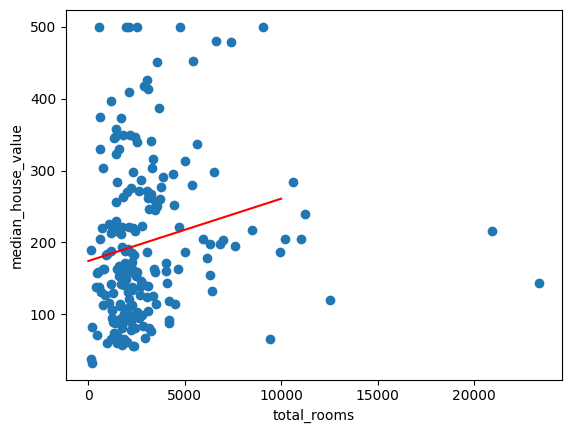

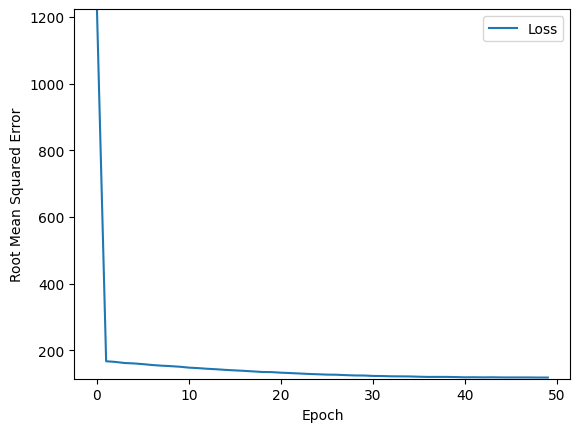

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 50
batch_size = 30

# Specify the feature and the label.
my_feature = "total_rooms"  # the total number of rooms on a specific city block.
my_label="median_house_value" # the median value of a house on a specific city block.
# That is, you're going to create a model that predicts house value based
# solely on total_rooms.

# Discard any pre-existing version of the model.
#my_model = None

# Invoke the functions.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df,
                                         my_feature, my_label,
                                         epochs, batch_size)

print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias )

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

A certain amount of randomness plays into training a model. Consequently, you'll get different results each time you train the model. That said, given the dataset and the hyperparameters, the trained model will generally do a poor job describing the feature's relation to the label.

# Use the model to make predictions

You can use the trained model to make predictions. In practice, [you should make predictions on examples that are not used in training](https://developers.google.com/machine-learning/crash-course/training-and-test-sets/splitting-data). However, for this lab, you'll just work with a subset of the same training dataset. A later Colab exercise will explore ways to make predictions on examples not used in training.

First, run the following code to define the house prediction function:

In [ ]:
def predict_house_values(n, feature, label):
  """Predict house values based on a feature."""

  batch = training_df[feature][10000:10000 + n]
  predicted_values = my_model.predict_on_batch(x=batch)

  print("feature   label          predicted")
  print("  value   value          value")
  print("          in thousand$   in thousand$")
  print("--------------------------------------")
  for i in range(n):
    print ("%5.0f %6.0f %15.0f" % (training_df[feature][10000 + i],
                                   training_df[label][10000 + i],
                                   predicted_values[i][0] ))

Now, invoke the house prediction function on 10 examples:

In [ ]:
predict_house_values(10, my_feature, my_label)

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
 1960     53             191
 3400     92             204
 3677     69             206
 2202     62             193
 2403     80             195
 5652    295             223
 3318    500             203
 2552    342             196
 1364    118             186
 3468    128             204


# Task 1: Judge the predictive power of the model

Look at the preceding table. How close is the predicted value to the label value?  In other words, does your model accurately predict house values?  

In [ ]:
#@title Double-click to view the answer.

# Most of the predicted values differ significantly
# from the label value, so the trained model probably
# doesn't have much predictive power. However, the
# first 10 examples might not be representative of
# the rest of the examples.

# Task 2: Try a different feature

The `total_rooms` feature had only a little predictive power. Would a different feature have greater predictive power?  Try using `population` as the feature instead of `total_rooms`.

Note: When you change features, you might also need to change the hyperparameters.

In [ ]:
my_feature = "?"   # Replace the ? with population or possibly
                   # a different column name.

# Experiment with the hyperparameters.
learning_rate = 2
epochs = 3
batch_size = 120

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df,
                                         my_feature, my_label,
                                         epochs, batch_size)
plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

predict_house_values(15, my_feature, my_label)

In [ ]:
#@title Double-click to view a possible solution.

my_feature = "population" # Pick a feature other than "total_rooms"

# Possibly, experiment with the hyperparameters.
learning_rate = 0.05
epochs = 18
batch_size = 3

# Don't change anything below.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df,
                                         my_feature, my_label,
                                         epochs, batch_size)

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

predict_house_values(10, my_feature, my_label)

Did `population` produce better predictions than `total_rooms`?

In [ ]:
#@title Double-click to view the answer.

# Training is not entirely deterministic, but population
# typically converges at a slightly higher RMSE than
# total_rooms.  So, population appears to be about
# the same or slightly worse at making predictions
# than total_rooms.

# Task 3: Define a synthetic feature

You have determined that `total_rooms` and `population` were not useful features.  That is, neither the total number of rooms in a neighborhood nor the neighborhood's population successfully predicted the median house price of that neighborhood. Perhaps though, the *ratio* of `total_rooms` to `population` might have some predictive power. That is, perhaps block density relates to median house value.

To explore this hypothesis, do the following:

1. Create a [synthetic feature](https://developers.google.com/machine-learning/glossary/#synthetic_feature) that's a ratio of `total_rooms` to `population`. (You may need to return to our previous Lab to learn how to add a new column in a dataframe)
2. Tune the three hyperparameters.
3. Determine whether this synthetic feature produces
   a lower loss value than any of the single features you
   tried earlier in this exercise.

In [ ]:
# Define a synthetic feature named rooms_per_person
training_df["rooms_per_person"] = ? # write your code here.

# Don't change the next line.
my_feature = "rooms_per_person"

# Assign values to these three hyperparameters.
learning_rate = ?
epochs = ?
batch_size = ?

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df,
                                         my_feature, my_label,
                                         epochs, batch_size)

plot_the_loss_curve(epochs, rmse)
predict_house_values(15, my_feature, my_label)

SyntaxError: invalid syntax (<ipython-input-7-b3a0c85a84f7>, line 2)

**Assignment 1: ⏬**

1.   Create a copy of the notebook and rename it with "your name".
2.   Study the Lab and solve Task 3.
3.   Share the file with me **only** at "badrm@sunypoly.edu".



What is your conclusion?

# Task 4. Find feature(s) whose raw values correlate with the label

So far, we've relied on trial-and-error to identify possible features for the model.  Let's rely on statistics instead.

A **correlation matrix** indicates how each attribute's raw values relate to the other attributes' raw values. Correlation values have the following meanings:

  * `1.0`: perfect positive correlation; that is, when one attribute rises, the other attribute rises.
  * `-1.0`: perfect negative correlation; that is, when one attribute rises, the other attribute falls.
  * `0.0`: no correlation; the two columns [are not linearly related](https://en.wikipedia.org/wiki/Correlation_and_dependence#/media/File:Correlation_examples2.svg).

In general, the higher the absolute value of a correlation value, the greater its predictive power. For example, a correlation value of -0.8 implies far more predictive power than a correlation of -0.2.

The following code cell generates the correlation matrix for attributes of the California Housing Dataset:

In [ ]:
# Generate a correlation matrix.
training_df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0


The correlation matrix shows nine potential features (including a synthetic
feature) and one label (`median_house_value`).  A strong negative correlation or strong positive correlation with the label suggests a potentially good feature.  

**Your Task:** Determine which of the nine potential features appears to be the best candidate for a feature?

In [ ]:
#@title Double-click here for the solution to Task 4

# The median_income correlates 0.7 with the label
# (median_house_value), so median_income might be a
# good feature. The other seven potential features
# all have a correlation relatively close to 0.

# Try median_income as the feature
# and see whether the model improves.

Correlation matrices don't tell the entire story. In later exercises, you'll find additional ways to unlock predictive power from potential features.